# Retinal pyramid / Color / Saccades

## Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os

In [4]:
import torch
torch.set_default_tensor_type('torch.DoubleTensor')

In [5]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,torch,POLO  -r -g -b

ModuleNotFoundError: No module named 'watermark'

## Images / saccades data

In [6]:
mode= 'bilinear' #resizing : continuous transition, reduces edges,contrast
width = 32 #side of the cropped image used to build the pyramid
base_levels = 2 #downsampling/upsampling factor

In [7]:
#name = 'i05june05_static_street_boston_p1010764'
#name = 'i05june05_static_street_boston_p1010785'
#name = 'i05june05_static_street_boston_p1010800'
#name = 'i05june05_static_street_boston_p1010806'
name = 'i05june05_static_street_boston_p1010808'
impath = '../data/'+name+'.jpeg'
locpath = '../data/'+name+'.pkl'

In [8]:
import pickle
f = open(locpath,'rb')
loc_dict = pickle.load(f)
loc_dict

{'image_name': 'i05june05_static_street_boston_p1010808',
 'barycenters': [(498, 384),
  (192, 425),
  (857, 437),
  (949, 513),
  (585, 546),
  (486, 288),
  (648, 415)]}

## Loading an image

In [9]:
from PIL import Image

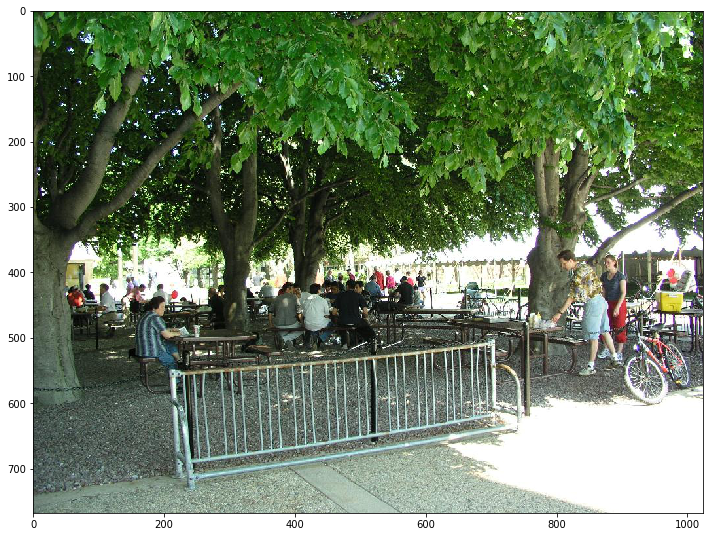

In [10]:
img_orig = Image.open(impath)

im_color_npy = np.asarray(img_orig)
N_X, N_Y, _ = im_color_npy.shape

ds= 1

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(im_color_npy)

In [11]:
img_tens = torch.Tensor(im_color_npy[None, ...]) 
img_tens = img_tens.permute(0,3,1,2)
print('Tensor shape=', img_tens.shape) #converting to a tensor format, image's size stored in img_tens.shape[-2:]

Tensor shape= torch.Size([1, 3, 768, 1024])


..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## Saccade path

In [12]:
loc_data_xy = np.array(loc_dict['barycenters'])
loc_data_ij = []
for coord in loc_data_xy:
    loc_data_ij += [[coord[1], coord[0]]]
loc_data_ij = np.array(loc_data_ij)
print(loc_data_xy)
print(loc_data_ij)

[[498 384]
 [192 425]
 [857 437]
 [949 513]
 [585 546]
 [486 288]
 [648 415]]
[[384 498]
 [425 192]
 [437 857]
 [513 949]
 [546 585]
 [288 486]
 [415 648]]


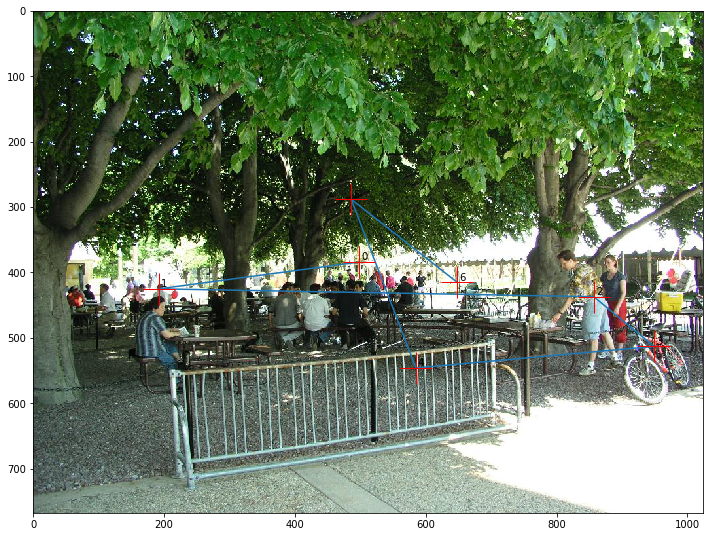

In [13]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(im_color_npy, cmap='gray')

ax.plot(loc_data_xy[:,0], loc_data_xy[:,1])
for i, coord in enumerate(loc_data_xy):
    ax.plot(coord[0], coord[1], 'r+', ms=32)
    ax.text(coord[0]+3, coord[1]-3, i)

In [14]:
orig = np.zeros(2, dtype='int')
orig[0] = N_X//2
orig[1] = N_Y//2
orig

array([384, 512])

In [15]:
def saccade_to(img_color, orig, loc_data_ij): 
    img_copy = np.copy(img_color)
    img_copy=np.roll(img_copy, orig[0] - loc_data_ij[0], axis=0)
    img_copy=np.roll(img_copy, orig[1] - loc_data_ij[1], axis=1)
    return img_copy  

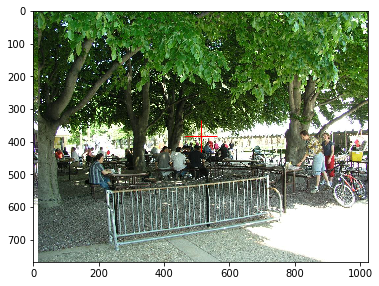

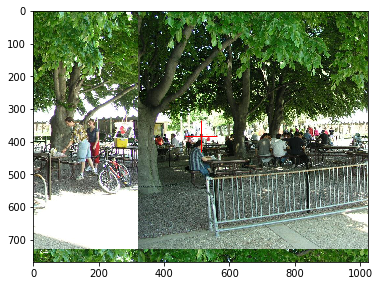

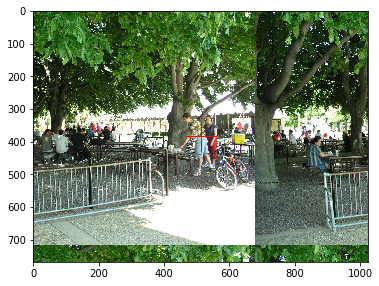

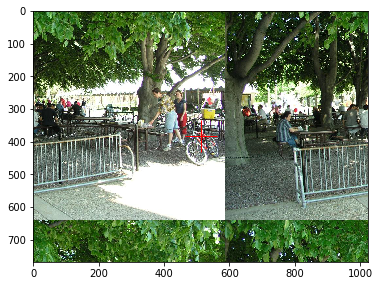

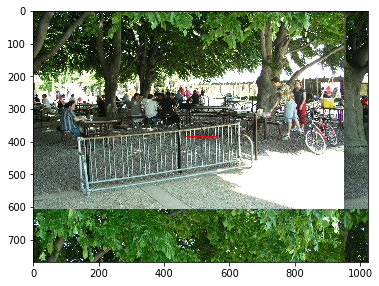

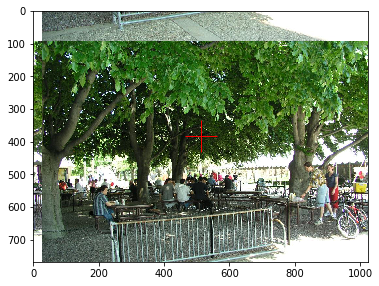

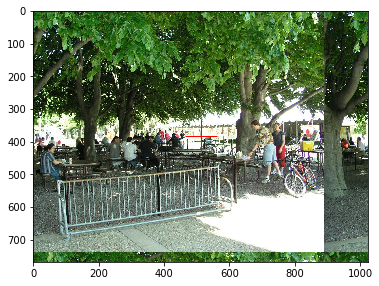

In [16]:
img_color_roll=[]
for i in range(len(loc_data_ij)):
    plt.figure(figsize=(6,6))
    #plt.imshow(img_color_roll[i])
    im_color_sac = saccade_to(im_color_npy, (N_X//2, N_Y//2), loc_data_ij[i])
    plt.imshow(im_color_sac)
    plt.plot(orig[1], orig[0], 'r+', ms=32)
    img_color_roll.append(im_color_sac)


# Using torch to build up a Laplacian pyramid


https://www.cs.tau.ac.il/~dcor/Graphics/Exercises/burt83laplacian.pdf

## Down-sampling recursively 

https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.interpolate


In [17]:
from torch.nn.functional import interpolate 

In [18]:
#Computing number of iterations to downsample the image to a size < width
n_levels = int(np.log(np.max(im_color_npy.shape)/width)/np.log(base_levels)) + 1 
print('Computed n_levels=', n_levels)

Computed n_levels= 6


Applying on the central crop of $32\times32$:

In [19]:
def cropped_pyramid(img_tens, width=width, base_levels=base_levels, verbose=False):
    
    N_batch, _, N_X, N_Y = img_tens.shape # tensor of the images  (dimension 4)
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1 #computing the number of iterations cf:downsampling
    
    img_crop = torch.zeros((N_batch, n_levels, 3, width, width)) #creating the tensor to store the cropped images while pyramiding

    img_down = img_tens.clone()
    level_size = [[N_X, N_Y]]
    for i_level in range(n_levels-1): #each iteration -> residual_image = image - downsampled_cloned_image_reshaped_to_the_right_size 
        img_residual = img_down.clone()
        img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode) #downsampling
        img_residual -= interpolate(img_down, size=img_residual.shape[-2:], mode=mode)  #upsizing in order to substract

        if verbose: print('Tensor shape=', img_down.shape, ', shape=', img_residual.shape)
        h_res, w_res = img_residual.shape[-2:] #at each iteration the residual image size is reduced of a factor 1/base_levels (img_down the image downsampled at the previous iteration)

        img_crop[:, i_level, :, :, :] = img_residual[:, :, 
                            (h_res//2-width//2):(h_res//2+width//2), 
                            (w_res//2-width//2):(w_res//2+width//2)] #the central crop of residual image stored in tensor img_crop
        level_size.append(list(img_down.shape[-2:]))

    h_res, w_res = img_down.shape[-2:]
    img_crop[:, n_levels-1, :, 
             (width//2-h_res//2):(width//2+h_res//2), 
             (width//2-w_res//2):(width//2+w_res//2)] = img_down #[0, :, :, :]
    if verbose: print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels) #print image's dimensions after downsampling, condition max(img_down.shape[-2:])<=width satisfied
    return img_crop, level_size


In [19]:
img_color_pyr_tens=[]
for i in range(len(loc_data_ij)):
    img_tens = torch.Tensor(img_color_roll[i][None, ...]) 
    img_tens = img_tens.permute(0,3,1,2)
    img_crop, level_size = cropped_pyramid(img_tens, verbose=False)
    img_color_pyr_tens.append(img_crop)
print(level_size)

C:\Anaconda3\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
C:\Anaconda3\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


[[768, 1024], [384, 512], [192, 256], [96, 128], [48, 64], [24, 32]]


Tensor shape= torch.Size([1, 6, 3, 32, 32])


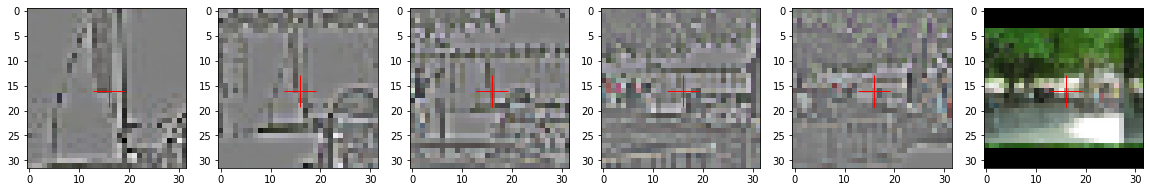

In [20]:
#displaying central crops from successive residual images
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
img_aff = img_crop.permute(0,1,3,4,2).numpy()
for i_level, ax in enumerate(axs):
    if i_level < n_levels-1:
        bias = 128
    else:
        bias = 0
    ax.imshow((img_aff[0, i_level, ...]+bias).astype('uint8'))
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_crop.shape)  

## Inverse pyramid from the coefficients

In [21]:
def inverse_pyramid(img_crop, N_X=N_X, N_Y=N_Y, base_levels=base_levels, verbose=False):
    N_batch = img_crop.shape[0] 
    width = img_crop.shape[3] 
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
    
    img_rec = img_crop[:, -1, :, :, :] #.unsqueeze(1)
    for i_level in range(n_levels-1)[::-1]: # from the top to the bottom of the pyramid
        img_rec = interpolate(img_rec, scale_factor=base_levels, mode=mode) #upsampling (factor=base_levels)
        h_res, w_res = img_rec.shape[-2:]
        img_rec[:, :, 
                (h_res//2-width//2):(h_res//2+width//2), 
                (w_res//2-width//2):(w_res//2+width//2)] += img_crop[:, i_level, :, :, :] #adding previous central crop to img_crop 
    img_rec = img_rec[:, :, (h_res//2-N_X//2):(h_res//2+N_X//2), (w_res//2-N_Y//2):(w_res//2+N_Y//2)]

    return img_rec

## Inverse pyramid from the coefficients

In [22]:
img_rec = inverse_pyramid(img_crop)

C:\Anaconda3\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


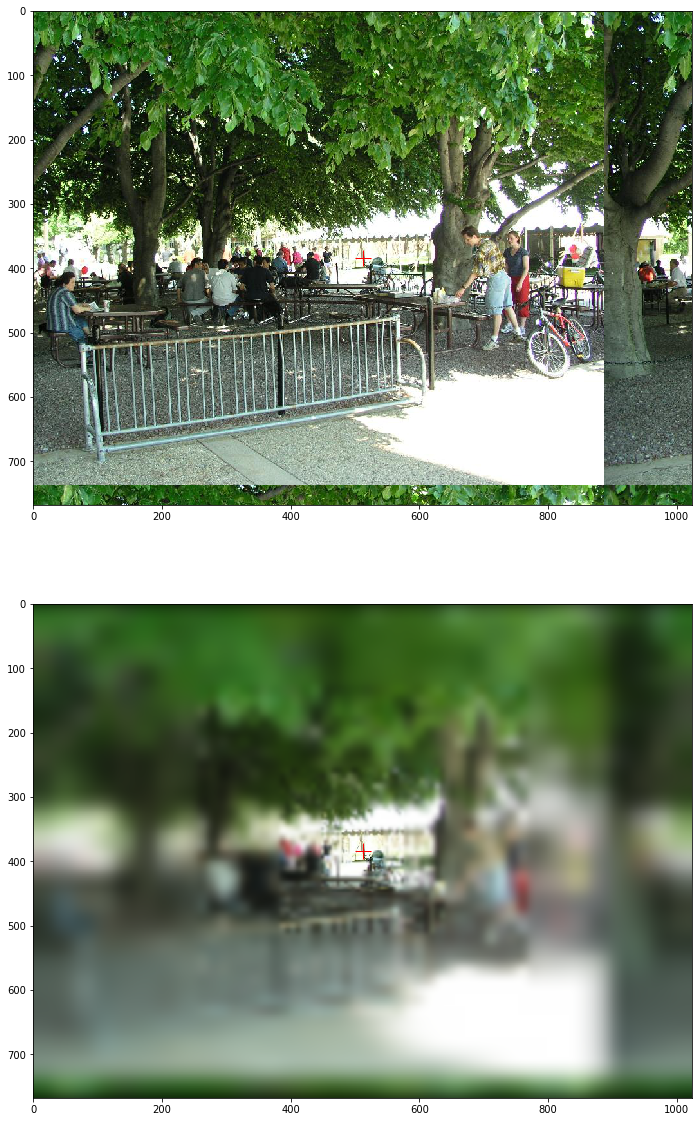

In [23]:
#Plotting reconstructed image
fig, axs = plt.subplots(2, 1, figsize=(20,20))
for ax, img in zip(axs, [img_tens, img_rec.detach()]):
    img = img.permute(0,2,3,1)[0,:,:,:]
    ax.imshow(img.numpy().astype('uint8'))
    ax.plot([N_Y//2], [N_X//2], 'r+', ms=16); #central cross

## With saccade data

In [24]:
img_color_pyr_rec=[]
for i in range(len(loc_data_ij)):
    img_color_pyr_rec.append(inverse_pyramid(img_color_pyr_tens[i], verbose=True))
    


C:\Anaconda3\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])


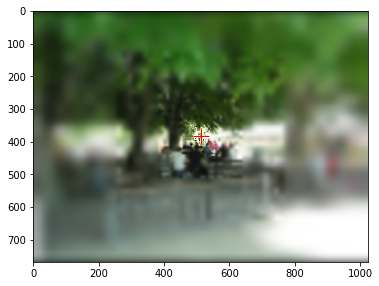

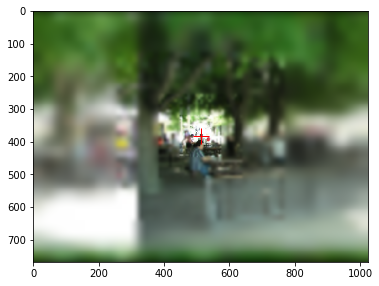

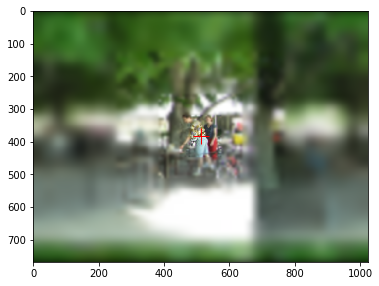

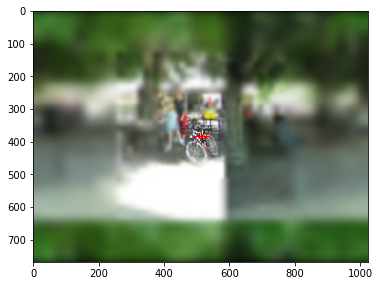

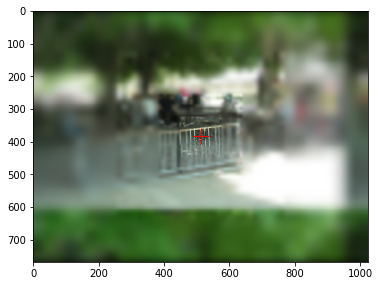

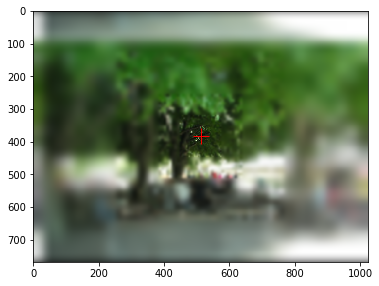

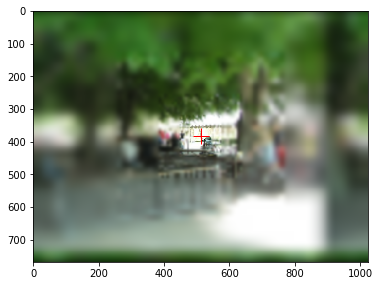

In [25]:
for i, img in enumerate(img_color_pyr_rec):
    plt.figure(figsize=(6,6))
    img_color_pyr_npy = img_color_pyr_rec[i].detach()  
    print(img_color_pyr_npy.shape)
    img_color_pyr_npy = img_color_pyr_npy.permute(0,2,3,1)[0,:,:,:]
    plt.imshow(img_color_pyr_npy.numpy().astype('uint8'))
    plt.plot([N_Y//2], [N_X//2], 'r+', ms=16); #central cross

# Reconstruction from multiple saccades

In [26]:
def tens_saccade_to(img_color_tens, orig, loc_data_ij): 
    img_copy = torch.clone(img_color_tens)
    img_copy = torch.roll(img_copy, (orig[0] - loc_data_ij[0],), (2,))
    img_copy = torch.roll(img_copy, (orig[1] - loc_data_ij[1],), (3,))
    return img_copy  

In [27]:
loc_data_ij[0] // 2**5

array([12, 15], dtype=int32)

In [28]:
def level_construct(img_crop_list, loc_data_ij, level_size, level):
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
    orig = level_size[0]//2, level_size[1]//2
    img_lev = torch.zeros((1, 3, level_size[0], level_size[1]))
    img_div = torch.zeros((1, 3, level_size[0], level_size[1]))
    #print(img_lev.shape)
    nb_saccades = len(img_crop_list)
    for num_saccade in range(nb_saccades):
        sac_img =  img_crop_list[num_saccade][:, level, :, :, :]
        if level_size[0] < width:
            x_width = level_size[0]
            sac_img = sac_img[:,:,width//2 - level_size[0]//2:width//2 + level_size[0]//2,:]
        else:
            x_width = width  
        if level_size[1] < width:
            y_width = level_size[1]
            sac_img = sac_img[:,:,:,width//2 - level_size[1]//2:width//2 + level_size[1]//2]  
        else:
            y_width = width
        #print(sac_img.shape)
            
        loc = loc_data_ij[num_saccade] // 2**level
        img_lev = tens_saccade_to(img_lev, orig, loc)
        img_lev[:,:,orig[0]-x_width//2:orig[0]+x_width//2, orig[1]-y_width//2:orig[1]+y_width//2] += sac_img 
        img_lev = tens_saccade_to(img_lev, loc, orig)
        img_div = tens_saccade_to(img_div, orig, loc)
        img_div[:,:,orig[0]-x_width//2:orig[0]+x_width//2, orig[1]-y_width//2:orig[1]+y_width//2] += torch.ones_like(sac_img) 
        img_div = tens_saccade_to(img_div, loc, orig)
    # Normalisation des coefficients    
    indices_zero = (img_div == 0).nonzero().detach().numpy()
    img_div_npy = img_div.detach().numpy()
    for ind in indices_zero:
        img_div_npy[ind[0], ind[1], ind[2], ind[3]] = 1
    img_lev = img_lev // img_div_npy
    plt.figure()
    if level < n_levels-1:
        bias = 128
    else:
        bias = 0
    img_aff = img_lev.detach().permute(0,2,3,1)[0,:,:,:].numpy()
    plt.imshow((img_aff+bias).astype('uint8'))
    return img_lev
    

In [29]:
def inverse_pyramid_saccades(img_crop_list, loc_data_ij, level_size, N_X=N_X, N_Y=N_Y, base_levels=base_levels, verbose=False):
    N_batch = img_crop.shape[0] 
    width = img_crop.shape[3] 
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
    
    #img_rec = img_crop[:, -1, :, :, :] #.unsqueeze(1)
    img_rec = level_construct(img_crop_list, loc_data_ij, level_size[n_levels-1], level=n_levels-1)
    for i_level in range(n_levels-1)[::-1]: # from the top to the bottom of the pyramid
        img_rec = interpolate(img_rec, scale_factor=base_levels, mode=mode) #upsampling (factor=base_levels)
        h_res, w_res = img_rec.shape[-2:]
        img_lev = level_construct(img_crop_list, loc_data_ij, level_size[i_level], level=i_level)
        img_rec += img_lev #adding previous central crop to img_crop 
    img_rec = img_rec[:, :, (h_res//2-N_X//2):(h_res//2+N_X//2), (w_res//2-N_Y//2):(w_res//2+N_Y//2)]

    return img_rec

## Test

C:\Anaconda3\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


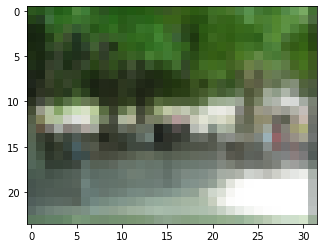

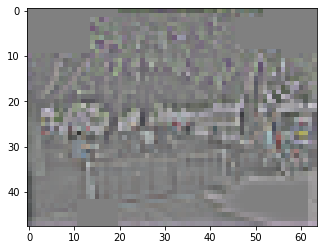

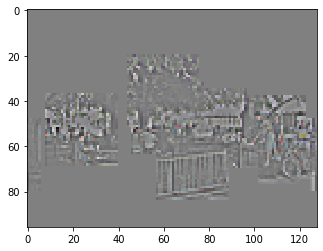

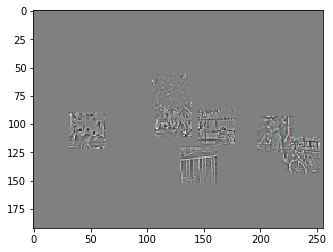

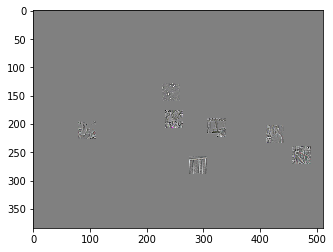

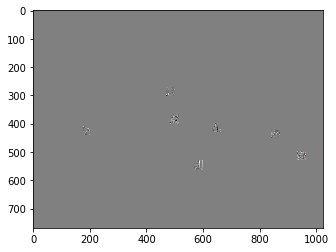

In [30]:


img_sac = inverse_pyramid_saccades(img_color_pyr_tens, loc_data_ij, level_size, verbose=True)


In [31]:
np.max(img_sac.detach().numpy().reshape((1,-1)))

306.48358154296875

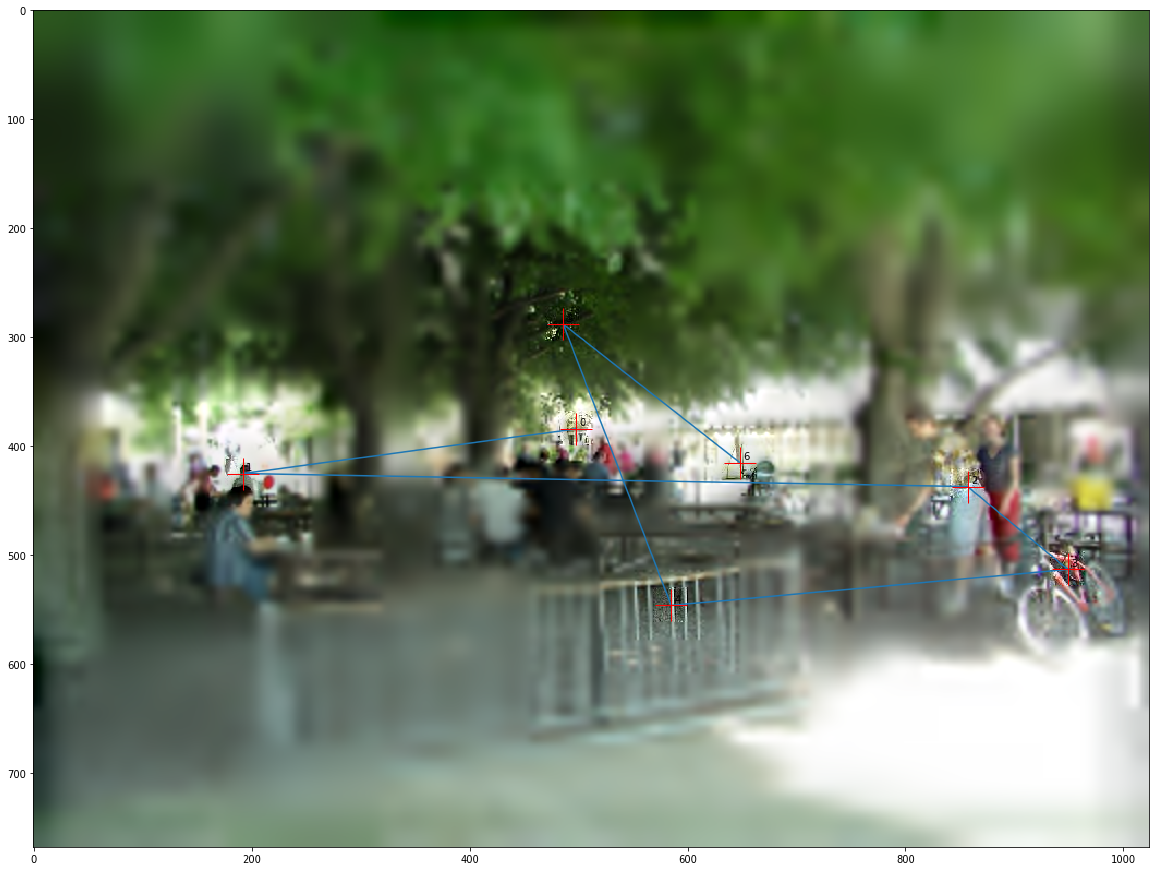

In [32]:
plt.figure(figsize=(20,20))
im = img_sac.detach().permute(0,2,3,1)[0,:,:,:].numpy()
im = np.clip(im,0,255).astype('uint8')

plt.imshow(im)
plt.plot(loc_data_ij[:,1], loc_data_ij[:,0])
for i, coord in enumerate(loc_dict['barycenters']):
    plt.plot(coord[0], coord[1], 'r+', ms=32)
    plt.text(coord[0]+3, coord[1]-3, i)